In [1]:
import h5py
import os
import numpy as np
from scipy import misc
from scipy import ndimage
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.cmap'] = 'gray'

/Users/deNsuh/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Create Dataset

In [4]:
# Uncomment below for actually creating the entire dataset from scratch
# filelist = os.listdir('./wbc_data')
# with h5py.File('dataset.h5', 'w') as new_f:
#     index = 0
#     for original_file_name in filelist:
#         if '.h5' not in original_file_name:
#             continue
#         # print('Opening file: {}'.format(original_file_name))

#         with h5py.File(os.path.join('wbc_data', original_file_name), 'r') as original_f:
#             o_data = original_f['dataset1']
#             shape = o_data.shape
#             group = new_f.create_group(str(index))
            
#             # identify the label
#             if 'B' in original_file_name:
#                 label = 'B'
#             elif 'CD4' in original_file_name:
#                 label = 'CD4'
#             else:
#                 label = 'CD8'
#             # print('this file\'s label : {}'.format(label))

            
#             # fill in the data
#             new_dset = group.create_dataset('data', shape, dtype='f')
#             new_dset[...] = np.array(o_data)
#             new_dset.attrs['label'] = label
#             new_dset.attrs['id'] = index
#             new_dset.attrs['original_name'] = original_file_name
            
#             index += 1

## how to access data points

In [4]:
with h5py.File('dataset.h5', 'r') as hf:
    for data_num in hf:
        label = hf[data_num]['data'].attrs['label']
        original_name = hf[data_num]['data'].attrs['original_name']
        id = hf[data_num]['data'].attrs['id']
    
    print('sample datapoints')
    data = np.array(hf['0']['data'])
    print(label)
    print(np.max(data))
    print(np.min(data))
    # print(data)

sample datapoints
B
1.41046
1.33104


## Normalizing

In [14]:
def normalize(img_array):
    min_val = np.min(img_array)
    max_val = np.max(img_array)
    
    img_array -= min_val
    
    multiplier = 1 / (max_val - min_val)
    
    return np.array(img_array) * multiplier

## Showing Image Test

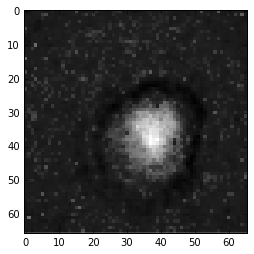

In [6]:
with h5py.File('dataset.h5', 'r') as hf:
    sample_data = normalize(np.array(hf['125']['data']))
    sample_slice = sample_data[22]
    plt.imshow(sample_slice)

## GIF test

In [29]:
import moviepy.editor as mpy

with h5py.File('dataset.h5', 'r') as hf:
    this_sample = np.array(hf['0']['data'])
    def make_frame(t):
        return this_sample[t].reshape((66, 66, 1))
    clip = mpy.VideoClip(make_frame, duration=66)
    clip.write_gif('test.gif', fps=15)


[MoviePy] Building file test.gif with imageio


100%|█████████▉| 990/991 [00:00<00:00, 1277.53it/s]


# Data Augmentation Test

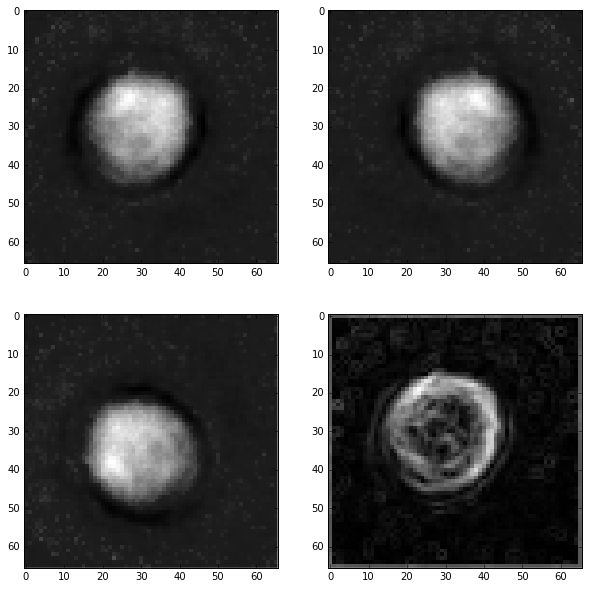

In [7]:
with h5py.File('dataset.h5', 'r') as hf:
    this_sample = normalize(np.array(hf['232']['data']))
    this_slice = this_sample[25]  # original
    
    # flipped slice
    flipped_slice = np.fliplr(this_slice)  # flip!
    rotated_slice = ndimage.rotate(this_slice, 90, reshape=False) # rotate!
    
    # edge-detection
    sob_x = ndimage.sobel(this_slice, axis=1, mode='constant')
    sob_y = ndimage.sobel(this_slice, axis=0, mode='constant')
    sob = np.hypot(sob_x, sob_y)
    sample_other_dim = normalize(np.array(hf['232']['data']))
    
    # now plot them
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(this_slice) # original
    plt.subplot(222)
    plt.imshow(flipped_slice)  # flipped
    plt.subplot(223)
    plt.imshow(rotated_slice)  # rotate
    plt.subplot(224)
    plt.imshow(sob)  # edge-detected

## Slicing data in different axis + translation

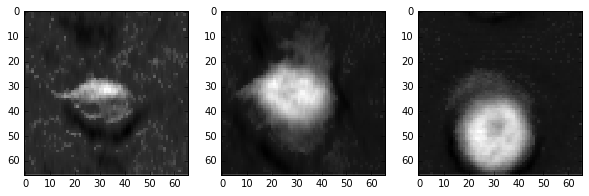

In [25]:
# (z, y, x) shape -> so sample[n] produces a slice through 'z' axis.
# to create a slice in 'y' axis, sample[:][y_val][:]
# for all z values, select the x-row in designated y-value and make a 2D image:
# for z in shape:
with h5py.File('dataset.h5', 'r') as hf:
    sample = normalize(np.array(hf['232']['data']))
    my_y = 12  # sample y-axis
    
    """
    y_slice = np.zeros((66, 66))
    for z_val, plane in enumerate(sample):
        x_row = plane[my_y]
        y_slice[z_val] = x_row
    """ 
    
    # 100x smarter way
    y_slice = sample[:, my_y, :]
    
    # plot it
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(y_slice)
    
# slice it through x-axis    
with h5py.File('dataset.h5', 'r') as hf:
    sample = normalize(np.array(hf['232']['data']))
    my_x = 34
    
    """
    x_slice = np.zeros((66, 66))
    for z_val, plane in enumerate(sample):
        y_row = plane[:, my_x]
        x_slice[z_val] = y_row
    """ 
    # easy as fuck
    x_slice = sample[:, :, my_x]
    
    # plot it
    plt.subplot(132)
    plt.imshow(x_slice)
    
# rolling
with h5py.File('dataset.h5', 'r') as hf:
    sample = normalize(np.array(hf['232']['data']))
    my_z = 34
    z_slice = sample[my_z]
    
    # roll the sample over
    z_slice = np.roll(z_slice, 20, axis=0)
    # z_slice = np.roll(z_slice, 20, axis=1)  # different direction
    # z_slice = np.roll(z_slice, 20)  # in both directions (all axes)
    
    # plot it
    plt.subplot(133)
    plt.imshow(z_slice)

# Creating Augmented Dataset

In [6]:
def add_data(h5file, new_data, label, index, name, shape, is_train):
    group = h5file.create_group(str(index))
    dataset = group.create_dataset('data', shape, dtype='f')
    dataset[...] = new_data
    dataset.attrs['label'] = label
    dataset.attrs['id'] = index
    dataset.attrs['name'] = name
    dataset.attrs['is_train'] = is_train

In [54]:
with h5py.File('dataset.h5', 'r') as hf, h5py.File('augmented_dataset.h5', 'w') as aug_hf:
    max_num = 0
    for data_num in hf:
        if max_num < int(data_num):
            max_num = int(data_num)
            
    # start with new index
    new_id = 0
    
    for data_num in hf:
        print('Augmenting for: {}'.format(data_num))
        # extract information from original data
        original_data = normalize(np.array(hf[data_num]['data']))  # now we save the normalized data!
        shape = original_data.shape
        label = hf[data_num]['data'].attrs['label']
        original_name = hf[data_num]['data'].attrs['original_name']
        original_id = hf[data_num]['data'].attrs['id']
        
        # agument data
        flipped_data = np.zeros(shape)  # flipped - up/down
        flipped_data_lr = np.zeros(shape) # flipped - left/right
        rotated_ninety = np.zeros(shape)  # 90deg rotation
        rotated_180 = np.zeros(shape)  # 180deg rotation
        rotated_270 = np.zeros(shape)  # 270deg rotation
        
        for z_val, z_plane in enumerate(original_data):
            flipped_data[z_val] = np.flipud(z_plane)
            flipped_data_lr[z_val] = np.fliplr(z_plane)
            rotated_ninety[z_val] = ndimage.rotate(z_plane, 90, reshape=False)
            rotated_180[z_val] = ndimage.rotate(z_plane, 180, reshape=False)
            rotated_270[z_val] = ndimage.rotate(z_plane, 270, reshape=False)
            
        # save the data    
        add_data(aug_hf, original_data, label, new_id, original_name, shape)  # original
        new_id += 1
        add_data(aug_hf, flipped_data, label, new_id, original_name + '_flipped_ud', shape)
        new_id += 1
        add_data(aug_hf, flipped_data_lr, label, new_id, original_name + '_flipped_lr', shape)
        new_id += 1
        add_data(aug_hf, rotated_ninety, label, new_id, original_name + '_rotated_90', shape)
        new_id += 1
        add_data(aug_hf, rotated_180, label, new_id, original_name + '_rotated_180', shape)
        new_id += 1
        add_data(aug_hf, rotated_270, label, new_id, original_name + '_rotated_270', shape)
        new_id += 1
        
print('Data Augmentation Complete')

Augmenting for: 0
Augmenting for: 1
Augmenting for: 10
Augmenting for: 100
Augmenting for: 101
Augmenting for: 102
Augmenting for: 103
Augmenting for: 104
Augmenting for: 105
Augmenting for: 106
Augmenting for: 107
Augmenting for: 108
Augmenting for: 109
Augmenting for: 11
Augmenting for: 110
Augmenting for: 111
Augmenting for: 112
Augmenting for: 113
Augmenting for: 114
Augmenting for: 115
Augmenting for: 116
Augmenting for: 117
Augmenting for: 118
Augmenting for: 119
Augmenting for: 12
Augmenting for: 120
Augmenting for: 121
Augmenting for: 122
Augmenting for: 123
Augmenting for: 124
Augmenting for: 125
Augmenting for: 126
Augmenting for: 127
Augmenting for: 128
Augmenting for: 129
Augmenting for: 13
Augmenting for: 130
Augmenting for: 131
Augmenting for: 132
Augmenting for: 133
Augmenting for: 134
Augmenting for: 135
Augmenting for: 136
Augmenting for: 137
Augmenting for: 138
Augmenting for: 139
Augmenting for: 14
Augmenting for: 140
Augmenting for: 141
Augmenting for: 142
Augmentin

## Test augmented data

CD8
Tomo_3_CD8_150113_1 (11).h5_rotated_180
2141


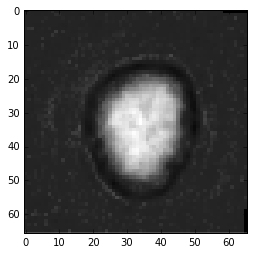

In [66]:
# Test augmented data
with h5py.File('augmented_dataset.h5', 'r') as aug_hf:
    sample = aug_hf['988']['data']
    label = aug_hf['988']['data'].attrs['label']
    print(label)
    print(sample.attrs['name'])
    print(np.max([int(x) for x in aug_hf]))  # max id
    plt.imshow(sample[25])

# More slices

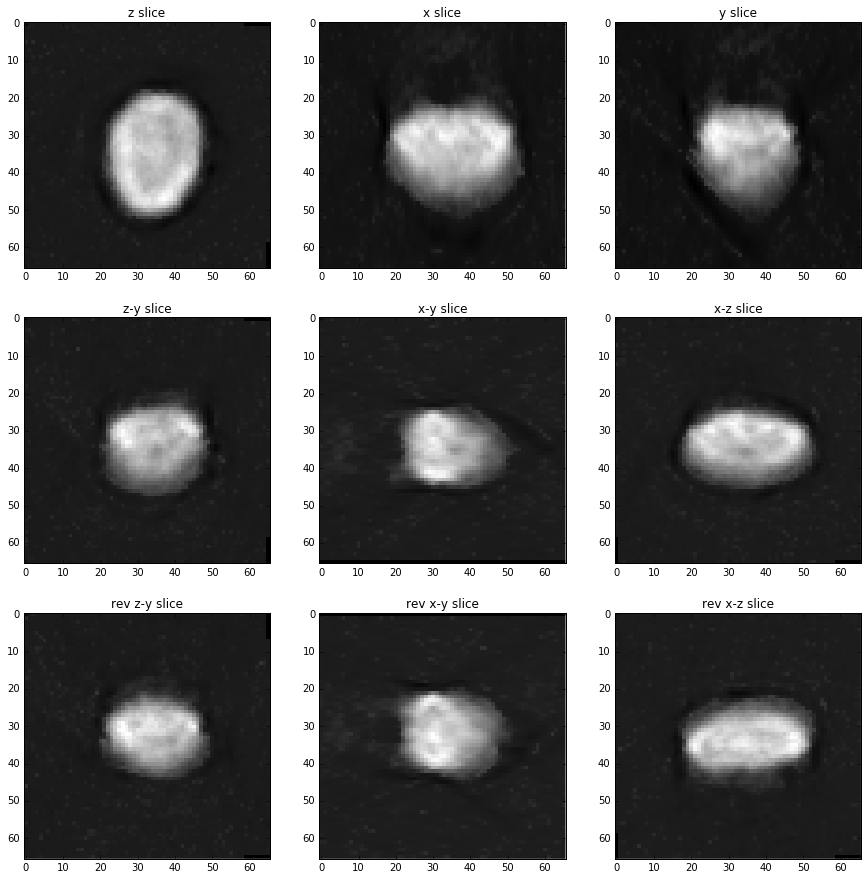

In [34]:
with h5py.File('augmented_dataset.h5', 'r') as hf:
    sample = hf['988']['data']
    z_slice = sample[32]
    x_slice = sample[:, :, 32]
    y_slice = sample[:, 32, :]
    
    z_y_slice = []
    for i in range(66):
        x_row = sample[i, i, :]
        z_y_slice.append(x_row)
    z_y_slice = np.array(z_y_slice)
    
    x_y_slice = []
    for i in range(66):
        z_row = sample[:, i, i]
        x_y_slice.append(z_row)
    x_y_slice = np.array(x_y_slice)
    
    x_z_slice = []
    for i in range(66):
        y_row = sample[i, :, i]
        x_z_slice.append(y_row)
    x_z_slice = np.array(x_z_slice)
    
    rev_z_y_slice = []
    for i in range(66):
        x_row = sample[i, (65 - i), :]
        rev_z_y_slice.append(x_row)
    rev_z_y_slice = np.array(rev_z_y_slice)
    
    rev_x_y_slice = []
    for i in range(66):
        z_row = sample[:, i, (65 - i)]
        rev_x_y_slice.append(z_row)
    rev_x_y_slice = np.array(rev_x_y_slice)
    
    rev_x_z_slice = []
    for i in range(66):
        y_row = sample[(65 - i), :, i]
        rev_x_z_slice.append(y_row)
    rev_x_z_slice = np.array(rev_x_z_slice)
    
    # draw figures
    plt.figure(figsize=(15, 15))
    plt.subplot(331)
    plt.title('z slice')
    plt.imshow(z_slice)
    
    plt.subplot(332)
    plt.title('x slice')
    plt.imshow(x_slice)
    
    plt.subplot(333)
    plt.title('y slice')
    plt.imshow(y_slice)
    
    plt.subplot(334)
    plt.title('z-y slice')
    plt.imshow(z_y_slice)
    
    plt.subplot(335)
    plt.title('x-y slice')
    plt.imshow(x_y_slice)
    
    plt.subplot(336)
    plt.title('x-z slice')
    plt.imshow(x_z_slice)
    
    plt.subplot(337)
    plt.title('rev z-y slice')
    plt.imshow(rev_z_y_slice)
    
    plt.subplot(338)
    plt.title('rev x-y slice')
    plt.imshow(rev_x_y_slice)
    
    plt.subplot(339)
    plt.title('rev x-z slice')
    plt.imshow(rev_x_z_slice)

# Data Augmentation 2 (with translations)

In [15]:
with open('train_test_idx.txt', 'r') as f:
    lines = f.readlines()
    train_indexes, test_indexes = tuple([line.strip().split(',') for line in lines])
    

with h5py.File('dataset.h5', 'r') as hf, h5py.File('augmented_dataset_2.h5', 'w') as aug_hf:
    max_num = 0
    for data_num in hf:
        if max_num < int(data_num):
            max_num = int(data_num)
            
    # start with new index
    new_id = 0
    
    for data_num in hf:
        print('Augmenting(2) for: {}'.format(data_num))
        # extract information from original data
        original_data = normalize(np.array(hf[data_num]['data']))  # now we save the normalized data!
        shape = original_data.shape
        max_z = shape[0]  # the size of z axis
        label = hf[data_num]['data'].attrs['label']
        original_name = hf[data_num]['data'].attrs['original_name']
        original_id = hf[data_num]['data'].attrs['id']
        
        if data_num in train_indexes:
            is_train = 'train'
        else:
            is_train = 'test'
        
        # agument data
        flipped_data = np.zeros(shape)  # flipped - up/down
        flipped_data_lr = np.zeros(shape) # flipped - left/right
        rotated_ninety = np.zeros(shape)  # 90deg rotation
        rotated_180 = np.zeros(shape)  # 180deg rotation
        rotated_270 = np.zeros(shape)  # 270deg rotation
        translated_3_right = np.zeros(shape) # 3 to the right (x-axis)
        translated_3_down = np.zeros(shape) # 3 pixels down (y-axis)
        translated_3_z = np.zeros(shape) # 3 pixels to the z-axis (plane switches)
        translated_5_left = np.zeros(shape)
        translated_5_up = np.zeros(shape)
        
        # construct augmented images
        for z_val, z_plane in enumerate(original_data):
            flipped_data[z_val] = np.flipud(z_plane)
            flipped_data_lr[z_val] = np.fliplr(z_plane)
            rotated_ninety[z_val] = ndimage.rotate(z_plane, 90, reshape=False)
            rotated_180[z_val] = ndimage.rotate(z_plane, 180, reshape=False)
            rotated_270[z_val] = ndimage.rotate(z_plane, 270, reshape=False)
            translated_3_right[z_val] = np.roll(z_plane, 3, axis=1)
            translated_3_down[z_val] = np.roll(z_plane, 3, axis=0)
            translated_5_left[z_val] = np.roll(z_plane, -5, axis=1)
            translated_5_up[z_val] = np.roll(z_plane, -5, axis=0)
            
            translated_z = (z_val + 3) % max_z  # new index
            translated_3_z[translated_z] = z_plane
            
        # save the data    
        add_data(aug_hf, original_data, label, new_id, original_name, shape, is_train)  # original
        new_id += 1
        add_data(aug_hf, flipped_data, label, new_id, original_name + '_flipped_ud', shape, is_train)
        new_id += 1
        add_data(aug_hf, flipped_data_lr, label, new_id, original_name + '_flipped_lr', shape, is_train)
        new_id += 1
        add_data(aug_hf, rotated_ninety, label, new_id, original_name + '_rotated_90', shape, is_train)
        new_id += 1
        add_data(aug_hf, rotated_180, label, new_id, original_name + '_rotated_180', shape, is_train)
        new_id += 1
        add_data(aug_hf, rotated_270, label, new_id, original_name + '_rotated_270', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_3_right, label, new_id, original_name + '_trans_3_right', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_3_down, label, new_id, original_name + '_trans_3_down', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_5_up, label, new_id, original_name + '_trans_5_up', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_5_left, label, new_id, original_name + '_trans_5_left', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_3_z, label, new_id, original_name + '_trans_3_z', shape, is_train)
        new_id += 1


print('Data Augmentation 2 Complete')

Augmenting(2) for: 0
Augmenting(2) for: 1
Augmenting(2) for: 10
Augmenting(2) for: 100
Augmenting(2) for: 101
Augmenting(2) for: 102
Augmenting(2) for: 103
Augmenting(2) for: 104
Augmenting(2) for: 105
Augmenting(2) for: 106
Augmenting(2) for: 107
Augmenting(2) for: 108
Augmenting(2) for: 109
Augmenting(2) for: 11
Augmenting(2) for: 110
Augmenting(2) for: 111
Augmenting(2) for: 112
Augmenting(2) for: 113
Augmenting(2) for: 114
Augmenting(2) for: 115
Augmenting(2) for: 116
Augmenting(2) for: 117
Augmenting(2) for: 118
Augmenting(2) for: 119
Augmenting(2) for: 12
Augmenting(2) for: 120
Augmenting(2) for: 121
Augmenting(2) for: 122
Augmenting(2) for: 123
Augmenting(2) for: 124
Augmenting(2) for: 125
Augmenting(2) for: 126
Augmenting(2) for: 127
Augmenting(2) for: 128
Augmenting(2) for: 129
Augmenting(2) for: 13
Augmenting(2) for: 130
Augmenting(2) for: 131
Augmenting(2) for: 132
Augmenting(2) for: 133
Augmenting(2) for: 134
Augmenting(2) for: 135
Augmenting(2) for: 136
Augmenting(2) for: 

# Data preprocessing (erasing water)

In [10]:
with h5py.File('dataset.h5', 'r') as hf, h5py.File('water_erased_dataset.h5', 'w') as we_hf:
    # test
    od = np.array(hf['0']['data'])
    we = od * (od > 1.35)
    # print(we)
    
    for data_num in hf:
        # extract information from original data
        # original_data = normalize(np.array(hf[data_num]['data']))  # now we save the normalized data!
        original_data = np.array(hf[data_num]['data'])
        water_erased = original_data * (original_data > 1.34)
        
        shape = original_data.shape
        label = hf[data_num]['data'].attrs['label']
        original_name = hf[data_num]['data'].attrs['original_name']
        original_id = hf[data_num]['data'].attrs['id']
        
        # save the data    
        add_data(we_hf, water_erased, label, data_num, original_name + '_no_water', shape)
print('done')

done


In [5]:
min_val = 10
max_val = 0
with h5py.File('water_erased_dataset.h5', 'r') as hf_nowater:
    for data_num in hf_nowater:
        sample = np.array(hf_nowater[data_num]['data'])
        flattened_samp = sample.flatten()
        nonzero_samps = np.nonzero(flattened_samp)
        samp_min = np.min(flattened_samp[nonzero_samps])
        samp_max = np.max(flattened_samp[nonzero_samps])
        
        min_val = samp_min if samp_min < min_val else min_val
        max_val = samp_max if samp_max > max_val else max_val
print(max_val)
print(min_val)

def no_water_normalize(img_array, val_max, val_min):
    # flattened = img_array.flatten()
    # min_val = np.min(flattened[np.nonzero(flattened)])
    # max_val = np.max(flattened[np.nonzero(flattened)])
    img_array -= val_min
    img_array = img_array * (img_array > -val_min)
    multiplier = 1 / (val_max - val_min)
    
    return np.array(img_array) * multiplier

1.42913
1.34


B
Tomo_1_B_160111_1 (29).h5_no_water


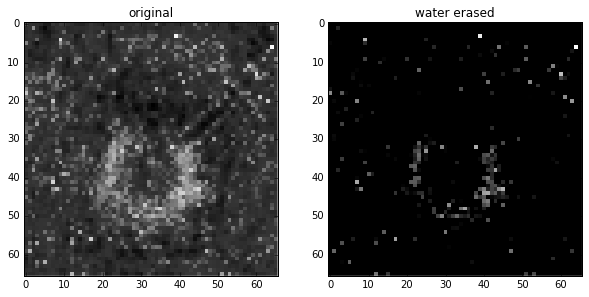

In [18]:
# print sample data
with h5py.File('water_erased_dataset.h5', 'r') as we_hf, h5py.File('dataset.h5', 'r') as hf:
    original_sample = normalize(np.array(hf['120']['data']))
    slice_original = original_sample[18]
    sample = no_water_normalize(np.array(we_hf['120']['data']), max_val, min_val)
    slice_ = sample[18]
    
    print(we_hf['120']['data'].attrs['label'])
    print(we_hf['120']['data'].attrs['name'])
    
    # draw figure
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.title('original')
    plt.imshow(slice_original)
    
    plt.subplot(122)
    plt.title('water erased')
    plt.imshow(slice_)

# Augmenting no-water data

In [8]:
with h5py.File('water_erased_dataset.h5', 'r') as hf, h5py.File('augmented_dataset_nowater.h5', 'w') as aug_hf:
    max_num = 0
    for data_num in hf:
        if max_num < int(data_num):
            max_num = int(data_num)
            
    # start with new index
    new_id = 0
    
    for data_num in hf:
        print('Augmenting for: {}'.format(data_num))
        # extract information from original data
        # now we save the normalized data!
        original_data = no_water_normalize(np.array(hf[data_num]['data']), max_val, min_val)
        shape = original_data.shape
        max_z = shape[0]  # the size of z axis
        label = hf[data_num]['data'].attrs['label']
        original_name = hf[data_num]['data'].attrs['name']
        original_id = hf[data_num]['data'].attrs['id']
        
        # agument data
        flipped_data = np.zeros(shape)  # flipped - up/down
        flipped_data_lr = np.zeros(shape) # flipped - left/right
        rotated_ninety = np.zeros(shape)  # 90deg rotation
        rotated_180 = np.zeros(shape)  # 180deg rotation
        rotated_270 = np.zeros(shape)  # 270deg rotation
        translated_3_right = np.zeros(shape) # 3 to the right (x-axis)
        translated_3_down = np.zeros(shape) # 3 pixels down (y-axis)
        translated_3_z = np.zeros(shape) # 3 pixels to the z-axis (plane switches)
        translated_5_left = np.zeros(shape)
        translated_5_up = np.zeros(shape)
        
        # construct augmented images
        for z_val, z_plane in enumerate(original_data):
            flipped_data[z_val] = np.flipud(z_plane)
            flipped_data_lr[z_val] = np.fliplr(z_plane)
            rotated_ninety[z_val] = ndimage.rotate(z_plane, 90, reshape=False)
            rotated_180[z_val] = ndimage.rotate(z_plane, 180, reshape=False)
            rotated_270[z_val] = ndimage.rotate(z_plane, 270, reshape=False)
            translated_3_right[z_val] = np.roll(z_plane, 3, axis=1)
            translated_3_down[z_val] = np.roll(z_plane, 3, axis=0)
            translated_5_left[z_val] = np.roll(z_plane, -5, axis=1)
            translated_5_up[z_val] = np.roll(z_plane, -5, axis=0)
            
            translated_z = (z_val + 3) % max_z  # new index
            translated_3_z[translated_z] = z_plane
            
        # save the data    
        add_data(aug_hf, original_data, label, new_id, original_name, shape)  # original
        new_id += 1
        add_data(aug_hf, flipped_data, label, new_id, original_name + '_flipped_ud', shape)
        new_id += 1
        add_data(aug_hf, flipped_data_lr, label, new_id, original_name + '_flipped_lr', shape)
        new_id += 1
        add_data(aug_hf, rotated_ninety, label, new_id, original_name + '_rotated_90', shape)
        new_id += 1
        add_data(aug_hf, rotated_180, label, new_id, original_name + '_rotated_180', shape)
        new_id += 1
        add_data(aug_hf, rotated_270, label, new_id, original_name + '_rotated_270', shape)
        new_id += 1
        add_data(aug_hf, translated_3_right, label, new_id, original_name + '_trans_3_right', shape)
        new_id += 1
        add_data(aug_hf, translated_3_down, label, new_id, original_name + '_trans_3_down', shape)
        new_id += 1
        add_data(aug_hf, translated_5_up, label, new_id, original_name + '_trans_5_up', shape)
        new_id += 1
        add_data(aug_hf, translated_5_left, label, new_id, original_name + '_trans_5_left', shape)
        new_id += 1
        add_data(aug_hf, translated_3_z, label, new_id, original_name + '_trans_3_z', shape)
        new_id += 1


print('Data Augmentation For No-Water data Complete')

Augmenting for: 0
Augmenting for: 1
Augmenting for: 10
Augmenting for: 100
Augmenting for: 101
Augmenting for: 102
Augmenting for: 103
Augmenting for: 104
Augmenting for: 105
Augmenting for: 106
Augmenting for: 107
Augmenting for: 108
Augmenting for: 109
Augmenting for: 11
Augmenting for: 110
Augmenting for: 111
Augmenting for: 112
Augmenting for: 113
Augmenting for: 114
Augmenting for: 115
Augmenting for: 116
Augmenting for: 117
Augmenting for: 118
Augmenting for: 119
Augmenting for: 12
Augmenting for: 120
Augmenting for: 121
Augmenting for: 122
Augmenting for: 123
Augmenting for: 124
Augmenting for: 125
Augmenting for: 126
Augmenting for: 127
Augmenting for: 128
Augmenting for: 129
Augmenting for: 13
Augmenting for: 130
Augmenting for: 131
Augmenting for: 132
Augmenting for: 133
Augmenting for: 134
Augmenting for: 135
Augmenting for: 136
Augmenting for: 137
Augmenting for: 138
Augmenting for: 139
Augmenting for: 14
Augmenting for: 140
Augmenting for: 141
Augmenting for: 142
Augmentin

# Split-augmentation (augmenting only the train cases)

In [7]:
# obtain train dataset index
with open('train_idx.txt', 'r') as f:
    line = f.readline()
    train_indexes = line.strip().split(',')
    
with h5py.File('water_erased_dataset.h5', 'r') as hf, h5py.File('augmented_dataset_nowater.h5', 'w') as aug_hf:
    # start with a new index
    new_id = 0
    for data_num in hf:
        print('Augmenting for: {}'.format(data_num))
        # extract information from original data
        # now we save the normalized data!
        original_data = no_water_normalize(np.array(hf[data_num]['data']),
                                           max_val, min_val)
        shape = original_data.shape
        max_z = shape[0]  # the size of z axis
        label = hf[data_num]['data'].attrs['label']
        original_name = hf[data_num]['data'].attrs['name']
        original_id = hf[data_num]['data'].attrs['id']

        if data_num in train_indexes:
            is_train = 'train'
        else:
            is_train = 'test'

        # agument data
        flipped_data = np.zeros(shape)  # flipped - up/down
        flipped_data_lr = np.zeros(shape) # flipped - left/right
        rotated_ninety = np.zeros(shape)  # 90deg rotation
        rotated_180 = np.zeros(shape)  # 180deg rotation
        rotated_270 = np.zeros(shape)  # 270deg rotation
        translated_3_right = np.zeros(shape) # 3 to the right (x-axis)
        translated_3_down = np.zeros(shape) # 3 pixels down (y-axis)
        translated_3_z = np.zeros(shape) # 3 pixels to the z-axis (plane switches)
        translated_5_left = np.zeros(shape)
        translated_5_up = np.zeros(shape)

        # construct augmented images
        for z_val, z_plane in enumerate(original_data):
            flipped_data[z_val] = np.flipud(z_plane)
            flipped_data_lr[z_val] = np.fliplr(z_plane)
            rotated_ninety[z_val] = ndimage.rotate(z_plane, 90, reshape=False)
            rotated_180[z_val] = ndimage.rotate(z_plane, 180, reshape=False)
            rotated_270[z_val] = ndimage.rotate(z_plane, 270, reshape=False)
            translated_3_right[z_val] = np.roll(z_plane, 3, axis=1)
            translated_3_down[z_val] = np.roll(z_plane, 3, axis=0)
            translated_5_left[z_val] = np.roll(z_plane, -5, axis=1)
            translated_5_up[z_val] = np.roll(z_plane, -5, axis=0)

            translated_z = (z_val + 3) % max_z  # new index
            translated_3_z[translated_z] = z_plane

        # save the data    
        add_data(aug_hf, original_data, label, new_id, original_name, shape, is_train + 'original')  # original
        new_id += 1
        add_data(aug_hf, flipped_data, label, new_id, original_name + '_flipped_ud', shape, is_train)
        new_id += 1
        add_data(aug_hf, flipped_data_lr, label, new_id, original_name + '_flipped_lr', shape, is_train)
        new_id += 1
        add_data(aug_hf, rotated_ninety, label, new_id, original_name + '_rotated_90', shape, is_train)
        new_id += 1
        add_data(aug_hf, rotated_180, label, new_id, original_name + '_rotated_180', shape, is_train)
        new_id += 1
        add_data(aug_hf, rotated_270, label, new_id, original_name + '_rotated_270', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_3_right, label, new_id, original_name + '_trans_3_right', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_3_down, label, new_id, original_name + '_trans_3_down', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_5_up, label, new_id, original_name + '_trans_5_up', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_5_left, label, new_id, original_name + '_trans_5_left', shape, is_train)
        new_id += 1
        add_data(aug_hf, translated_3_z, label, new_id, original_name + '_trans_3_z', shape, is_train)
        new_id += 1


print('Data Augmentation For No-Water data Complete')

Augmenting for: 0
Augmenting for: 1
Augmenting for: 10
Augmenting for: 100
Augmenting for: 101
Augmenting for: 102
Augmenting for: 103
Augmenting for: 104
Augmenting for: 105
Augmenting for: 106
Augmenting for: 107
Augmenting for: 108
Augmenting for: 109
Augmenting for: 11
Augmenting for: 110
Augmenting for: 111
Augmenting for: 112
Augmenting for: 113
Augmenting for: 114
Augmenting for: 115
Augmenting for: 116
Augmenting for: 117
Augmenting for: 118
Augmenting for: 119
Augmenting for: 12
Augmenting for: 120
Augmenting for: 121
Augmenting for: 122
Augmenting for: 123
Augmenting for: 124
Augmenting for: 125
Augmenting for: 126
Augmenting for: 127
Augmenting for: 128
Augmenting for: 129
Augmenting for: 13
Augmenting for: 130
Augmenting for: 131
Augmenting for: 132
Augmenting for: 133
Augmenting for: 134
Augmenting for: 135
Augmenting for: 136
Augmenting for: 137
Augmenting for: 138
Augmenting for: 139
Augmenting for: 14
Augmenting for: 140
Augmenting for: 141
Augmenting for: 142
Augmentin

In [18]:
with h5py.File('augmented_dataset_nowater.h5') as hf:
    print(hf['1']['data'].attrs['is_train'])

test
